<a href="https://colab.research.google.com/github/SiMori92/reddit-NLP/blob/main/Inspection_%26_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Content
Data: 29 Oct 2023
number of sample: 19

- Pre 1: Load libraries
- Pre 2: Load data
  - split training set & testing set

1. Data inspection
  1. meta features
  2. Embeddings
    - Load the 2 popular embedding
    - Embeddings Coverage
    - generating the oov -> then check coverage
  3. N-gram analysis (for sentiment analysis)
    - uni
    - bi
    - tri
  4. sentiment distribution
  5. topic distribution (topic modeling algorithms (e.g., LDA, NMF))

2. Data processing
  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  2. Stemming or lemmatization
  3. clean the text with embedding (Glove/ Fasttext)
  4. Clean text per N-gram
  - goal: make the top 20 N-gram understandable
  5. Inspection after processing

3. Features engineering
  1. Frequency of words
    - N-grams
  2. Time-series
  3. Frequency of Emoji
  4. Count the number of positve comment vs negative comments
    - further: classification of comments
  5. Sentiment analysis on top n-grams
    - socre
    - embeddings and vectors
    
4. Prepare the Training dataset
- check for Duplicated labeled records

## Pre 1: Load libraries

In [1]:
# import library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string

import gc
import operator

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# popular Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

!pip install bert-tensorflow
from bert import tokenization

from collections import defaultdict

import seaborn as sns

from wordcloud import STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00


In [3]:
# tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

## Pre 2: Load data

In [4]:
#load excel
part1_df = pd.read_csv("2-15Jun2023.csv")
part2_df = pd.read_csv("16-28Jun2023.csv")

In [5]:
# combine df
consol_df = pd.concat([part1_df, part2_df], ignore_index=True)
consol_df

Unnamed: 0                                        title submission_id  \
0           12  What Are Your Moves Tomorrow, June 15, 2023       149hiod   
1           13  What Are Your Moves Tomorrow, June 14, 2023       148o6b6   
2           14  What Are Your Moves Tomorrow, June 13, 2023       147w58u   
3           15  What Are Your Moves Tomorrow, June 12, 2023       1473oh9   
4           16  What Are Your Moves Tomorrow, June 09, 2023       144jdol   
5           17  What Are Your Moves Tomorrow, June 08, 2023       143naj8   
6           18  What Are Your Moves Tomorrow, June 07, 2023       142rjni   
7           19  What Are Your Moves Tomorrow, June 06, 2023       141px3u   
8           20  What Are Your Moves Tomorrow, June 06, 2023       1416t5j   
9           21  What Are Your Moves Tomorrow, June 06, 2023       140ylaf   
10          22  What Are Your Moves Tomorrow, June 02, 2023       13xroz3   
11           3  What Are Your Moves Tomorrow, June 28, 2023       14knrbs   
12           4  What Are Your Moves Tomorrow, June 27, 2023       14jriu7   
13           5  What Are Your Moves Tomorrow, June 26, 2023       14ivnrn   
14           6  What Are Your Moves Tomorrow, June 23, 2023       14gdb6p   
15           7  What Are Your Moves Tomorrow, June 22, 2023       14fhpci   
16           8  What Are Your Moves Tomorrow, June 21, 2023       14elert   
17           9  What Are Your Moves Tomorrow, June 20, 2023       14doz0o   
18          10  What Are Your Moves Tomorrow, June 16, 2023       14abrd1   

                                             comments  
0   SPY historical average annual returns: 9%\n  \...  
1   I’m up 13% in  Carvana and 15% in Adobe. Too b...  
2   If anyone wants a good value stock, AAPL is tr...  
3   Can't wait till **Reddit IPO** for 3 reasons:\...  
4   This idiot sold his 235 Tesla call right befor...  
5   ✅ Fire CEO\n\n✅ Cancel conference call\n\n✅ Mi...  
6   Buy a TSLA call\n  \nImmediately lose ~20-30% ...  
7   I should move everything to t bills and never ...  
8   Flash crash rug pull black swan panic sell Bou...  
9   Which one of you fuckheads reported me to the ...  
10  All outta monies and coins. ![img](emote|t5_2t...  
11  Trades when I 15x: $300 invested\n\nTrades whe...  
12  I watched TSLA rise for 3 months. 3 months. 3 ...  
13  I was holding puts over the weekend. Thought f...  
14  It's only gambling if you occasionally win The...  
15  What if 99% of the comments here are just AI r...  
16  Submarine tours 75% off 🚨 Fed Ex has sucked si...  
17  Dear r/personalfinance ; I'm a 25 year old pro...  
18  I turned $1500 into 20k+ in three weeks\n\nUnf...

## 1. Data inspection

1. Meta features
2. Embedding coverage
3. N-gram analysis (for sentiment analysis)
  - uni
  - bi
  - tri
4. Sentiment distribution
5. Topic distribution (topic modeling algorithms (e.g., LDA, NMF))

##1.1. Meta Features (understand the structure)

In [6]:
# 2. Meta Features (understand the structure between training & test dataset)

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
               'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# word_count
consol_df['word_count'] = consol_df['comments'].apply(lambda x: len(str(x).split()))

# unique_word_count
consol_df['unique_word_count'] = consol_df['comments'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
consol_df['stop_word_count'] = consol_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
consol_df['url_count'] = consol_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
consol_df['mean_word_length'] = consol_df['comments'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
consol_df['char_count'] = consol_df['comments'].apply(lambda x: len(str(x)))

# punctuation_count
consol_df['punctuation_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
consol_df['hashtag_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
consol_df['mention_count'] = consol_df['comments'].apply(lambda x: len([c for c in str(x) if c == '@']))


In [7]:
consol_df.describe()

Unnamed: 0    word_count  unique_word_count  stop_word_count  \
count   19.000000     19.000000          19.000000        19.000000   
mean    12.578947  65878.210526       13600.157895     26858.421053   
std      6.067361  21224.030462        3376.956524      8738.937574   
min      3.000000  11247.000000        4081.000000      4351.000000   
25%      7.500000  56221.000000       12888.500000     22896.000000   
50%     13.000000  72595.000000       14651.000000     29293.000000   
75%     17.500000  76649.500000       15666.500000     31257.000000   
max     22.000000  90801.000000       17006.000000     36950.000000   

        url_count  mean_word_length     char_count  punctuation_count  \
count   19.000000         19.000000      19.000000          19.000000   
mean    83.052632          4.903925  390307.947368       21719.315789   
std     38.101434          0.053640  124885.096852        6718.786953   
min     21.000000          4.821534   66055.000000        3863.000000   
25%     54.500000          4.870761  334270.500000       18831.500000   
50%     83.000000          4.906016  426934.000000       23895.000000   
75%    105.500000          4.931859  458015.500000       25713.500000   
max    163.000000          5.021993  532792.000000       28749.000000   

       hashtag_count  mention_count  
count      19.000000      19.000000  
mean      110.315789      28.210526  
std        40.503844      25.461472  
min        22.000000       3.000000  
25%        85.500000       7.000000  
50%       117.000000      14.000000  
75%       137.000000      51.500000  
max       182.000000      74.000000

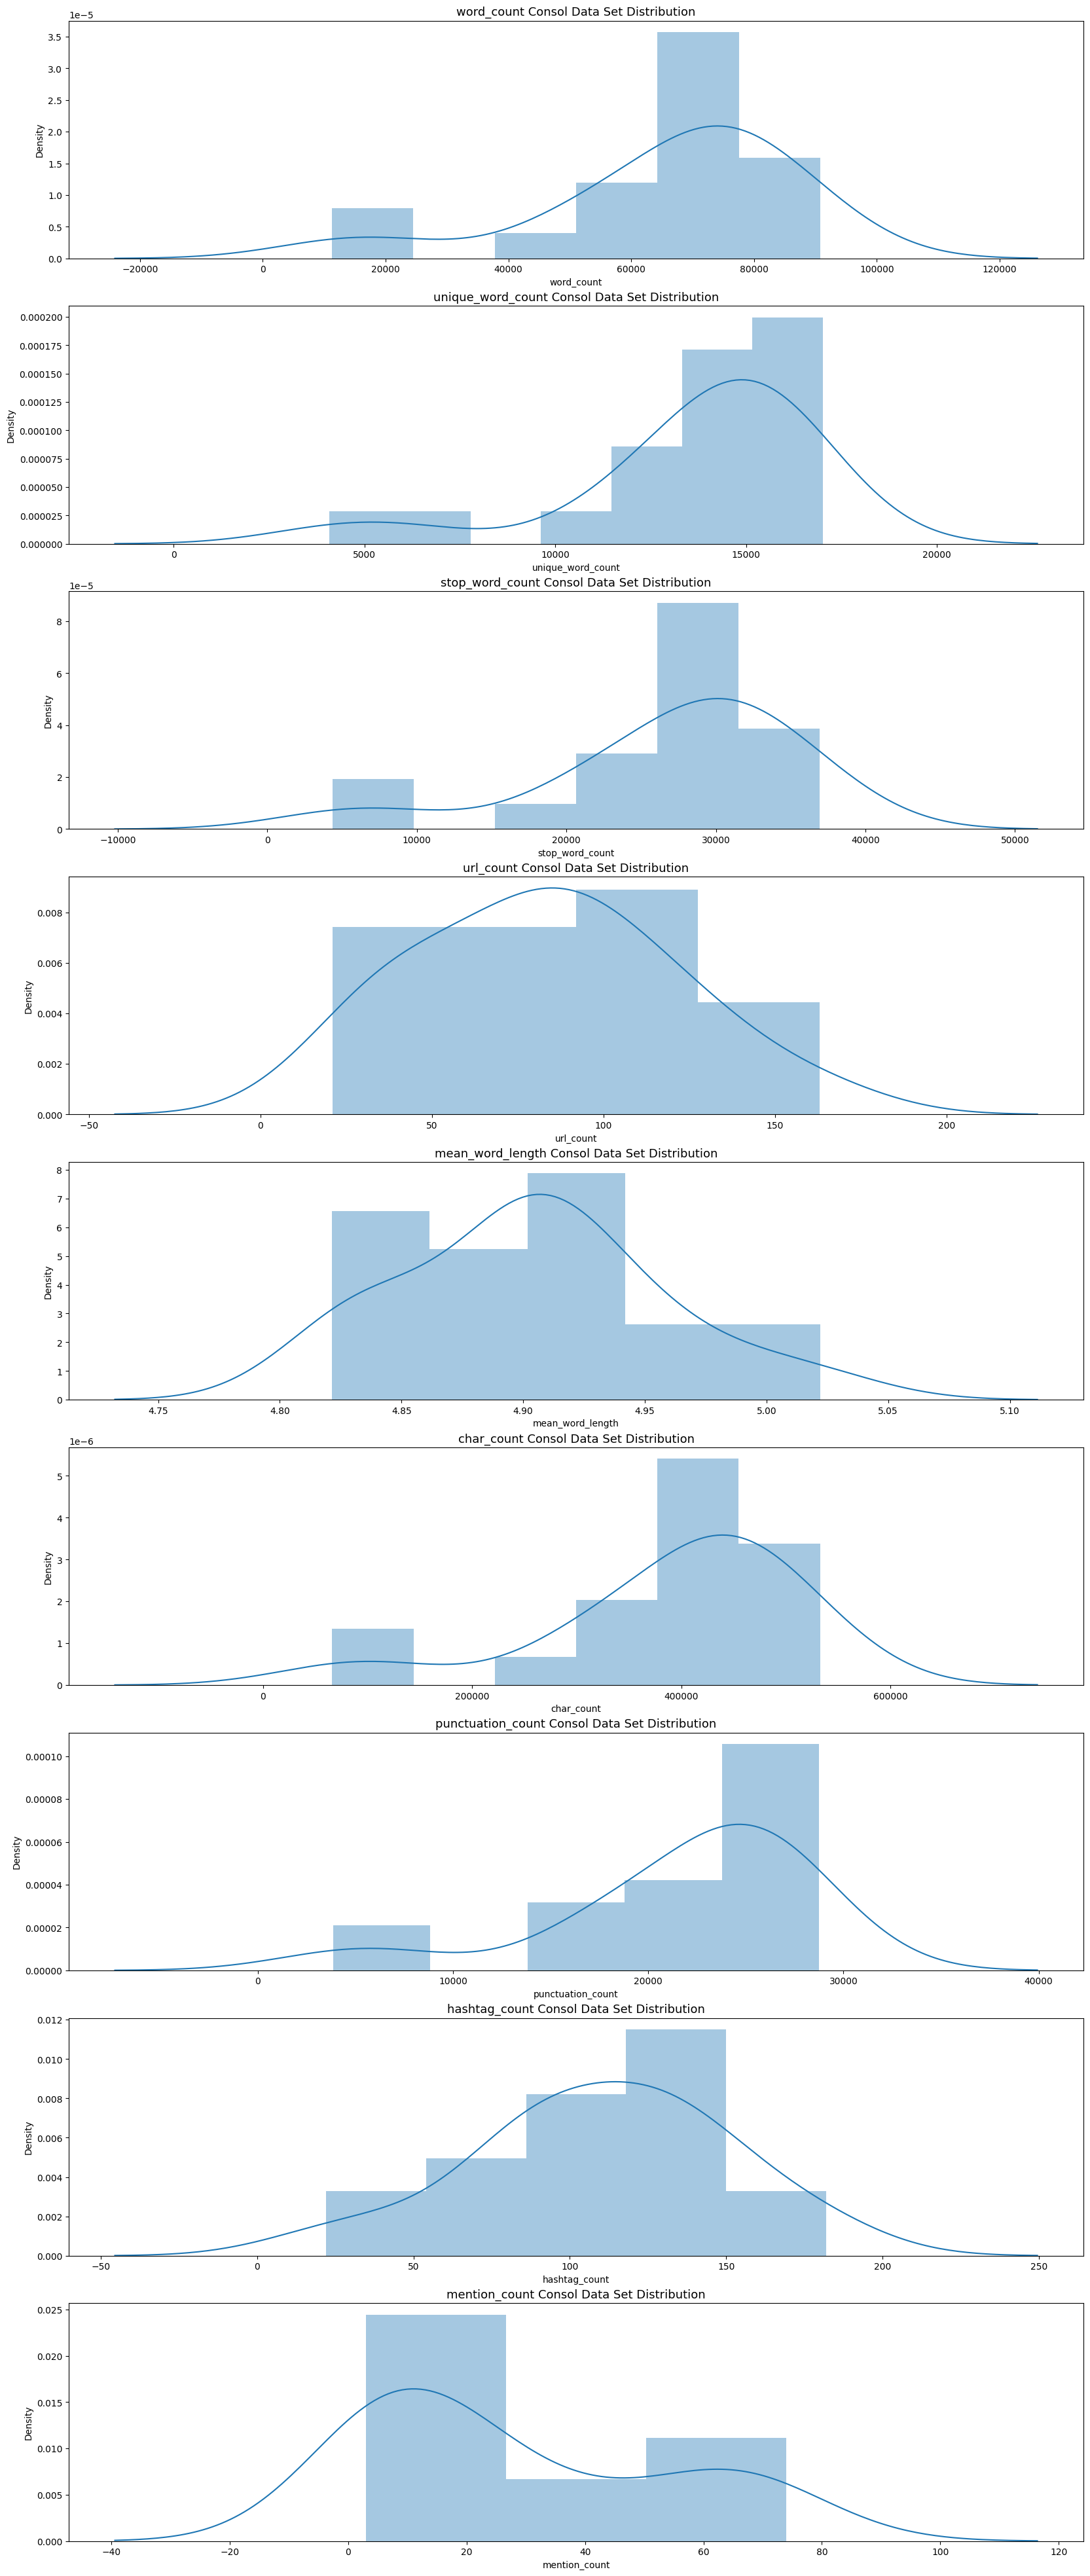

In [8]:
import warnings
warnings.filterwarnings("ignore")

# visualisation of meta features

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):

    sns.distplot(consol_df[feature], label='Consol', ax=axes[i])

    axes[i].set_title(f'{feature} Consol Data Set Distribution', fontsize=13)

plt.show()

## 1.2. Embeddings coverage

In [9]:
#Load the 2 popular embedding
#glove
#fasttext

fasttext_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/Embeddings/crawl-300d-2M-002-001.pkl', allow_pickle=True)
glove_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/Embeddings/glove.840B.300d-001-002.pkl', allow_pickle=True)

In [10]:
glove_embeddings

{',': array([-0.082752 ,  0.67204  , -0.14987  , -0.064983 ,  0.056491 ,
         0.40228  ,  0.0027747, -0.3311   , -0.30691  ,  2.0817   ,
         0.031819 ,  0.013643 ,  0.30265  ,  0.0071297, -0.5819   ,
        -0.2774   , -0.062254 ,  1.1451   , -0.24232  ,  0.1235   ,
        -0.12243  ,  0.33152  , -0.006162 , -0.30541  , -0.13057  ,
        -0.054601 ,  0.037083 , -0.070552 ,  0.5893   , -0.30385  ,
         0.2898   , -0.14653  , -0.27052  ,  0.37161  ,  0.32031  ,
        -0.29125  ,  0.0052483, -0.13212  , -0.052736 ,  0.087349 ,
        -0.26668  , -0.16897  ,  0.015162 , -0.0083746, -0.14871  ,
         0.23413  , -0.20719  , -0.091386 ,  0.40075  , -0.17223  ,
         0.18145  ,  0.37586  , -0.28682  ,  0.37289  , -0.16185  ,
         0.18008  ,  0.3032   , -0.13216  ,  0.18352  ,  0.095759 ,
         0.094916 ,  0.008289 ,  0.11761  ,  0.34046  ,  0.03677  ,
        -0.29077  ,  0.058303 , -0.027814 ,  0.082941 ,  0.1862   ,
        -0.031494 ,  0.27985  , -0.074412 ,

In [11]:
# Embeddings Coverage

# break the comments into words
# vocab is the unique words in the text data
def build_vocab(X):

    comments = X.apply(lambda s: s.split()).values
    vocab = {}

    for comment in comments:
        for word in comment:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋
            n_oov += vocab[word]

    #calculate the coverage
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

consol_glove_oov, consol_glove_vocab_coverage, consol_glove_text_coverage = check_embeddings_coverage(consol_df['comments'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Consol Set'.format(consol_glove_vocab_coverage, consol_glove_text_coverage))

consol_fasttext_oov, consol_fasttext_vocab_coverage, consol_fasttext_text_coverage = check_embeddings_coverage(consol_df['comments'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Consol Set'.format(consol_fasttext_vocab_coverage, consol_fasttext_text_coverage))

GloVe Embeddings cover 44.71% of vocabulary and 86.95% of text in Consol Set
FastText Embeddings cover 48.02% of vocabulary and 89.00% of text in Consol Set


In [12]:
# generating the oov
# The purpose of generating Out-of-Vocabulary (OOV) embeddings using FastText is to provide vector representations
# - for words that are not present in the original vocabulary of the pre-trained FastText model.
# combination of character n-grams, which allows it to
# - capture the meaning of words even if they are out-of-vocabulary or misspelled.
# OOV words can negatively impact the performance of the model, and having embeddings
# - for these words can help improve the accuracy and robustness of the model.

# lump the 2 oov list as one
mergedlist = consol_glove_oov + consol_fasttext_oov

# 將新列表轉換為集合，這將刪除重複的元素
unique_set = set(mergedlist)

# 將集合轉換為列表，以便返回
total_oov = list(unique_set)
df_total_oov = pd.DataFrame(total_oov, columns = ['oov', 'oov_counts'])

# sort the oov frequency
df_total_oov_sorted = df_total_oov.sort_values(by='oov_counts', ascending=False)

# Reset the index to maintain the original order
df_total_oov_sorted = df_total_oov_sorted.reset_index(drop=True)
df_total_oov_sorted

# save as new CSV
df_total_oov_sorted.to_csv('total_oov.csv')

print(f"The counts of records in Glove OOV list is {len(consol_glove_oov)}")
print(f"The counts of records in Fasttest OOV list is {len(consol_fasttext_oov)}")
print(f"The counts of records in Total OOV list is {len(total_oov)}")


The counts of records in Glove OOV list is 54759
The counts of records in Fasttest OOV list is 51472
The counts of records in Total OOV list is 56188


## 1.3. N-gram analysis (for sentiment analysis)

In [13]:
# 3. Ngrams(rank Ngrams in both labels)
# understand the info of Ngrams
# provide hints on text structure

def generate_ngrams(text, n_gram=1):
    # tokenisation
    # convert to lower case
    # split words based on spaces.
    # filter out empty tokens and stopwords
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]

    # grouping tokens to form n-grams
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    # joins the tokens within each ngram using the ' ' separator and as 1 string
    return [' '.join(ngram) for ngram in ngrams]

# visualisation how long of N-grams
N = 100

# Unigrams
consol_unigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt):
        consol_unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(consol_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
consol_bigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams[word] += 1

df_bigrams = pd.DataFrame(sorted(consol_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
consol_trigrams = defaultdict(int)

for cmt in consol_df['comments']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams[word] += 1

df_trigrams = pd.DataFrame(sorted(consol_trigrams.items(), key=lambda x: x[1])[::-1])

df_unigrams

0     1
0                  will  5113
1                 calls  3549
2                 going  3208
3                market  3037
4                    go  2943
...                 ...   ...
90885           early”,     1
90886                😃🍆     1
90887  today:\n\nbulls:     1
90888            \nnvda     1
90889              9%\n     1

[90890 rows x 2 columns]

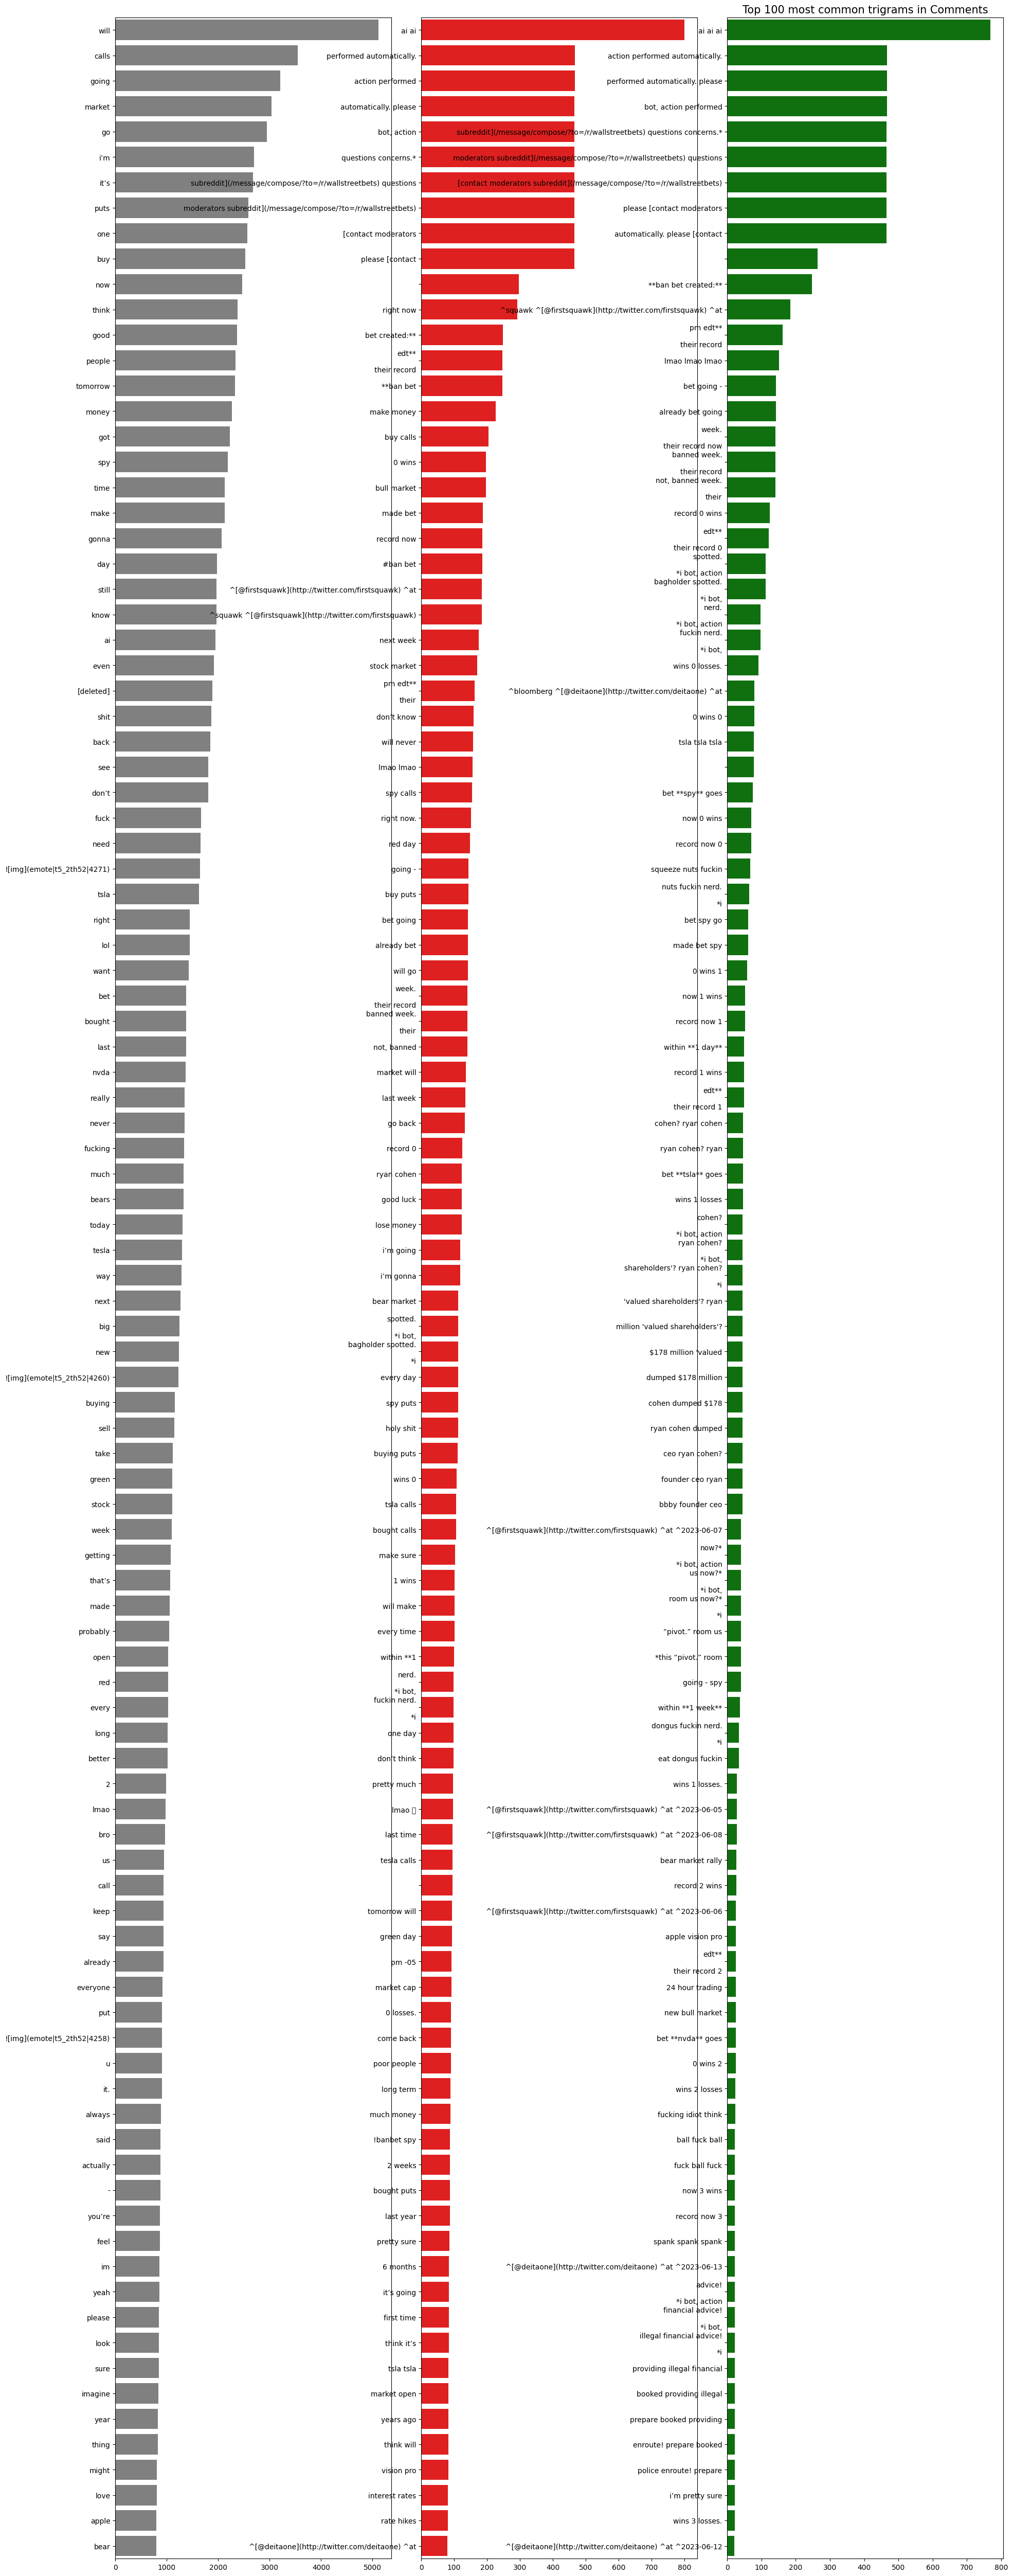

In [14]:
# 3. Ngrams
# visualisation for Unigrams
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams[0].values[:N], x=df_unigrams[1].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Comments', fontsize=15)

sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Comments', fontsize=15)

sns.barplot(y=df_trigrams[0].values[:N], x=df_trigrams[1].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Comments', fontsize=15)

plt.show()

In [15]:
# sentiment distribution
# apply if database built can identify each comments saperately
'''
sia = SentimentIntensityAnalyzer()
#apply sentiment analysis
consol_df['sentiment'] = consol_df['comments'].apply(lambda x: sia.polarity_scores(x))

# Initialize counters for different sentiment labels
positive_count = 0
negative_count = 0
neutral_count = 0

# Count the occurrences of each sentiment label
for scores in consol_df['sentiment']:
    compound_score = scores['compound']
    if compound_score > 0.05:
        positive_count += 1
    elif compound_score < -0.05:
        negative_count += 1
    else:
        neutral_count += 1

# Calculate the relative frequencies of each sentiment label
total_count = len(consol_df)
positive_percent = positive_count / total_count
negative_percent = negative_count / total_count
neutral_percent = neutral_count / total_count

# Visualize the sentiment distribution using a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percent, negative_percent, neutral_percent]
colors = ['green', 'red', 'gray']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()
'''

"\nsia = SentimentIntensityAnalyzer()\n#apply sentiment analysis\nconsol_df['sentiment'] = consol_df['comments'].apply(lambda x: sia.polarity_scores(x))\n\n# Initialize counters for different sentiment labels\npositive_count = 0\nnegative_count = 0\nneutral_count = 0\n\n# Count the occurrences of each sentiment label\nfor scores in consol_df['sentiment']:\n    compound_score = scores['compound']\n    if compound_score > 0.05:\n        positive_count += 1\n    elif compound_score < -0.05:\n        negative_count += 1\n    else:\n        neutral_count += 1\n\n# Calculate the relative frequencies of each sentiment label\ntotal_count = len(consol_df)\npositive_percent = positive_count / total_count\nnegative_percent = negative_count / total_count\nneutral_percent = neutral_count / total_count\n\n# Visualize the sentiment distribution using a pie chart\nlabels = ['Positive', 'Negative', 'Neutral']\nsizes = [positive_percent, negative_percent, neutral_percent]\ncolors = ['green', 'red', 'gra

In [16]:
# topic distribution (topic modeling algorithms (e.g., LDA, NMF))
# unsupervised classificaton
# apply if database built can identify each comments saperately
'''
'''

'\n'

## 2. Data processing

  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  2. Stemming or lemmatization
  3. clean the text with embedding (Glove/ Fasttext)
  4. Clean text per N-gram
  - goal: make the top 20 N-gram understandable
  5. Inspection after processing



## 2.1 clean the comments with neutral words


In [17]:
# option 1: NLTK - stop words

import nltk
from nltk.corpus import stopwords

In [18]:
# option 1: NLTK - stop words
# to clean the data set

# Get the stopwords
stopwords = stopwords.words('english')

# Apply preprocessing to each comment

#decode it with utf-8

consol_df['new_text'] = consol_df['comments'].apply(lambda text: text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore'))

'''
# Tokenization
# Split the raw text into individual tokens
consol_df['new_text'] = consol_df['new_text'].apply(word_tokenize)
'''

#convert to all small case

consol_df['new_text'] = consol_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords]))

# Print the updated DataFrame
print(consol_df)

    Unnamed: 0                                        title submission_id  \
0           12  What Are Your Moves Tomorrow, June 15, 2023       149hiod   
1           13  What Are Your Moves Tomorrow, June 14, 2023       148o6b6   
2           14  What Are Your Moves Tomorrow, June 13, 2023       147w58u   
3           15  What Are Your Moves Tomorrow, June 12, 2023       1473oh9   
4           16  What Are Your Moves Tomorrow, June 09, 2023       144jdol   
5           17  What Are Your Moves Tomorrow, June 08, 2023       143naj8   
6           18  What Are Your Moves Tomorrow, June 07, 2023       142rjni   
7           19  What Are Your Moves Tomorrow, June 06, 2023       141px3u   
8           20  What Are Your Moves Tomorrow, June 06, 2023       1416t5j   
9           21  What Are Your Moves Tomorrow, June 06, 2023       140ylaf   
10          22  What Are Your Moves Tomorrow, June 02, 2023       13xroz3   
11           3  What Are Your Moves Tomorrow, June 28, 2023       14knrbs   

In [19]:
# option 2: SK learn - ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)

frozenset({'go', 'whether', 'con', 'interest', 'thus', 'amount', 'nowhere', 'being', 'noone', 'others', 'perhaps', 'more', 'several', 'still', 'serious', 'again', 'ourselves', 'even', 'since', 'cant', 'three', 'by', 'around', 'among', 'ie', 'us', 'something', 'rather', 'bottom', 'they', 'during', 'cry', 'none', 'as', 'everywhere', 'their', 'were', 'would', 'yourself', 'his', 'than', 'whose', 'toward', 'thereupon', 'become', 'hereupon', 'mill', 'seem', 'are', 'always', 'it', 'below', 'is', 'in', 'formerly', 'never', 'few', 'un', 'however', 'ltd', 'whoever', 'show', 'yet', 'mostly', 'couldnt', 'put', 'your', 'back', 'has', 'detail', 'after', 'thick', 'them', 'please', 'no', 'must', 'can', 'under', 'but', 'own', 'same', 'that', 'be', 'much', 'whereafter', 'afterwards', 'take', 'such', 'wherever', 'me', 'with', 'many', 'eg', 'find', 'fill', 'keep', 'off', 'last', 'upon', 'became', 'other', 'for', 'six', 'every', 'top', 'nobody', 'thereafter', 'without', 'those', 'between', 'into', 'twelve'

In [20]:
# option 2: SK learn - ENGLISH_STOP_WORDS
# to clean the date set

# Get the stopwords
stopwords_sk = ENGLISH_STOP_WORDS

#convert to lower cases
# Apply preprocessing to each comment
consol_df['new_text'] = consol_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords_sk]))

# Print the updated DataFrame
print(consol_df)

    Unnamed: 0                                        title submission_id  \
0           12  What Are Your Moves Tomorrow, June 15, 2023       149hiod   
1           13  What Are Your Moves Tomorrow, June 14, 2023       148o6b6   
2           14  What Are Your Moves Tomorrow, June 13, 2023       147w58u   
3           15  What Are Your Moves Tomorrow, June 12, 2023       1473oh9   
4           16  What Are Your Moves Tomorrow, June 09, 2023       144jdol   
5           17  What Are Your Moves Tomorrow, June 08, 2023       143naj8   
6           18  What Are Your Moves Tomorrow, June 07, 2023       142rjni   
7           19  What Are Your Moves Tomorrow, June 06, 2023       141px3u   
8           20  What Are Your Moves Tomorrow, June 06, 2023       1416t5j   
9           21  What Are Your Moves Tomorrow, June 06, 2023       140ylaf   
10          22  What Are Your Moves Tomorrow, June 02, 2023       13xroz3   
11           3  What Are Your Moves Tomorrow, June 28, 2023       14knrbs   

## 2.2. clean the text with embedding (Glove/ Fasttext) - for sentiment analysis

In [21]:
# 1. clean the text with embedding
# clean the text
# then check coverage on the cleaned text again

%%time

# Convert 'consol_df['tokens']' column to string
consol_df['new_text'] = consol_df['new_text'].astype(str)

def clean(comment):


    # #1 - eomte

    emote_pattern = r"!\[img]\(emote\|[^)]*\)"  # Regex pattern to match the desired pattern
    comment = re.sub(emote_pattern,"", comment)


    # Urls
    comment = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", comment)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`’"
    for p in punctuations:
        comment = comment.replace(p, ' ')

    return comment

consol_df['embeddings_tokens'] = consol_df['new_text'].apply(lambda s : clean(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['embeddings_tokens'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['embeddings_tokens'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))


GloVe Embeddings cover 78.41% of vocabulary and 96.59% of text in Training Set
FastText Embeddings cover 77.97% of vocabulary and 96.80% of text in Training Set
CPU times: user 922 ms, sys: 0 ns, total: 922 ms
Wall time: 926 ms


In [22]:
# count the removed pattern
'''
def df_pattern(comment, df):

    emote_pattern = r"!\[img]\(emote\|[^)]*\)"  # Regex pattern to match the desired pattern
    matches = re.findall(emote_pattern, comment)
    pattern_counts = {}

      # Count the patterns
    for match in matches:
        if match in pattern_counts:
            pattern_counts[match] += 1
        else:
            pattern_counts[match] = 1

    df_input = pd.DataFrame({'Count': list(pattern_counts.values())}, index=list(pattern_counts.keys()))
    df_transposed = df.T
    df = df.append(df_transposed, ignore_index=False)

    return df

#initialise
df_pattern = pd.DataFrame()

# Create a dataframe from the pattern counts
df_pattern = (consol_df['new_text'],df_pattern).apply(lambda s : df_pattern(s))
df_pattern['date'] = consol_df['date']

'''

'\ndef df_pattern(comment, df):\n\n    emote_pattern = r"!\\[img]\\(emote\\|[^)]*\\)"  # Regex pattern to match the desired pattern\n    matches = re.findall(emote_pattern, comment)\n    pattern_counts = {}\n\n      # Count the patterns\n    for match in matches:\n        if match in pattern_counts:\n            pattern_counts[match] += 1\n        else:\n            pattern_counts[match] = 1\n\n    df_input = pd.DataFrame({\'Count\': list(pattern_counts.values())}, index=list(pattern_counts.keys()))\n    df_transposed = df.T\n    df = df.append(df_transposed, ignore_index=False)\n\n    return df\n\n#initialise\ndf_pattern = pd.DataFrame()\n\n# Create a dataframe from the pattern counts\ndf_pattern = (consol_df[\'new_text\'],df_pattern).apply(lambda s : df_pattern(s))\ndf_pattern[\'date\'] = consol_df[\'date\']\n\n'

In [23]:
# 1. clean the text with embedding
# save a copy of clean text

consol_df.to_csv('consol_df.csv')


In [24]:
consol_df = pd.read_csv('consol_df.csv')

In [25]:
# 1. clean the text with embedding
# After cleaning, glove_embeddings and fasttext_embeddings are deleted and garbage collected because they consume too much memory (10+ gigabytes).
'''
del glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,
gc.collect()
'''

'\ndel glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,\ngc.collect()\n'

In [26]:
# 2nd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['embeddings_tokens']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_second[word] += 1

df_unigrams_cleaned_second = pd.DataFrame(sorted(consol_unigrams_cleaned_second.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_second[word] += 1

df_bigrams_cleaned_second = pd.DataFrame(sorted(consol_bigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_second = defaultdict(int)

for cmt in consol_df['embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_second[word] += 1

df_trigrams_cleaned_second = pd.DataFrame(sorted(consol_trigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_second

grams  count
0                         ai ai    837
1               message compose    552
2                       2023 06    491
3        compose wallstreetbets    471
4       performed automatically    467
...                         ...    ...
466254            average daily      1
466255          nvda historical      1
466256                   9 nvda      1
466257                returns 9      1
466258           average annual      1

[466259 rows x 2 columns]

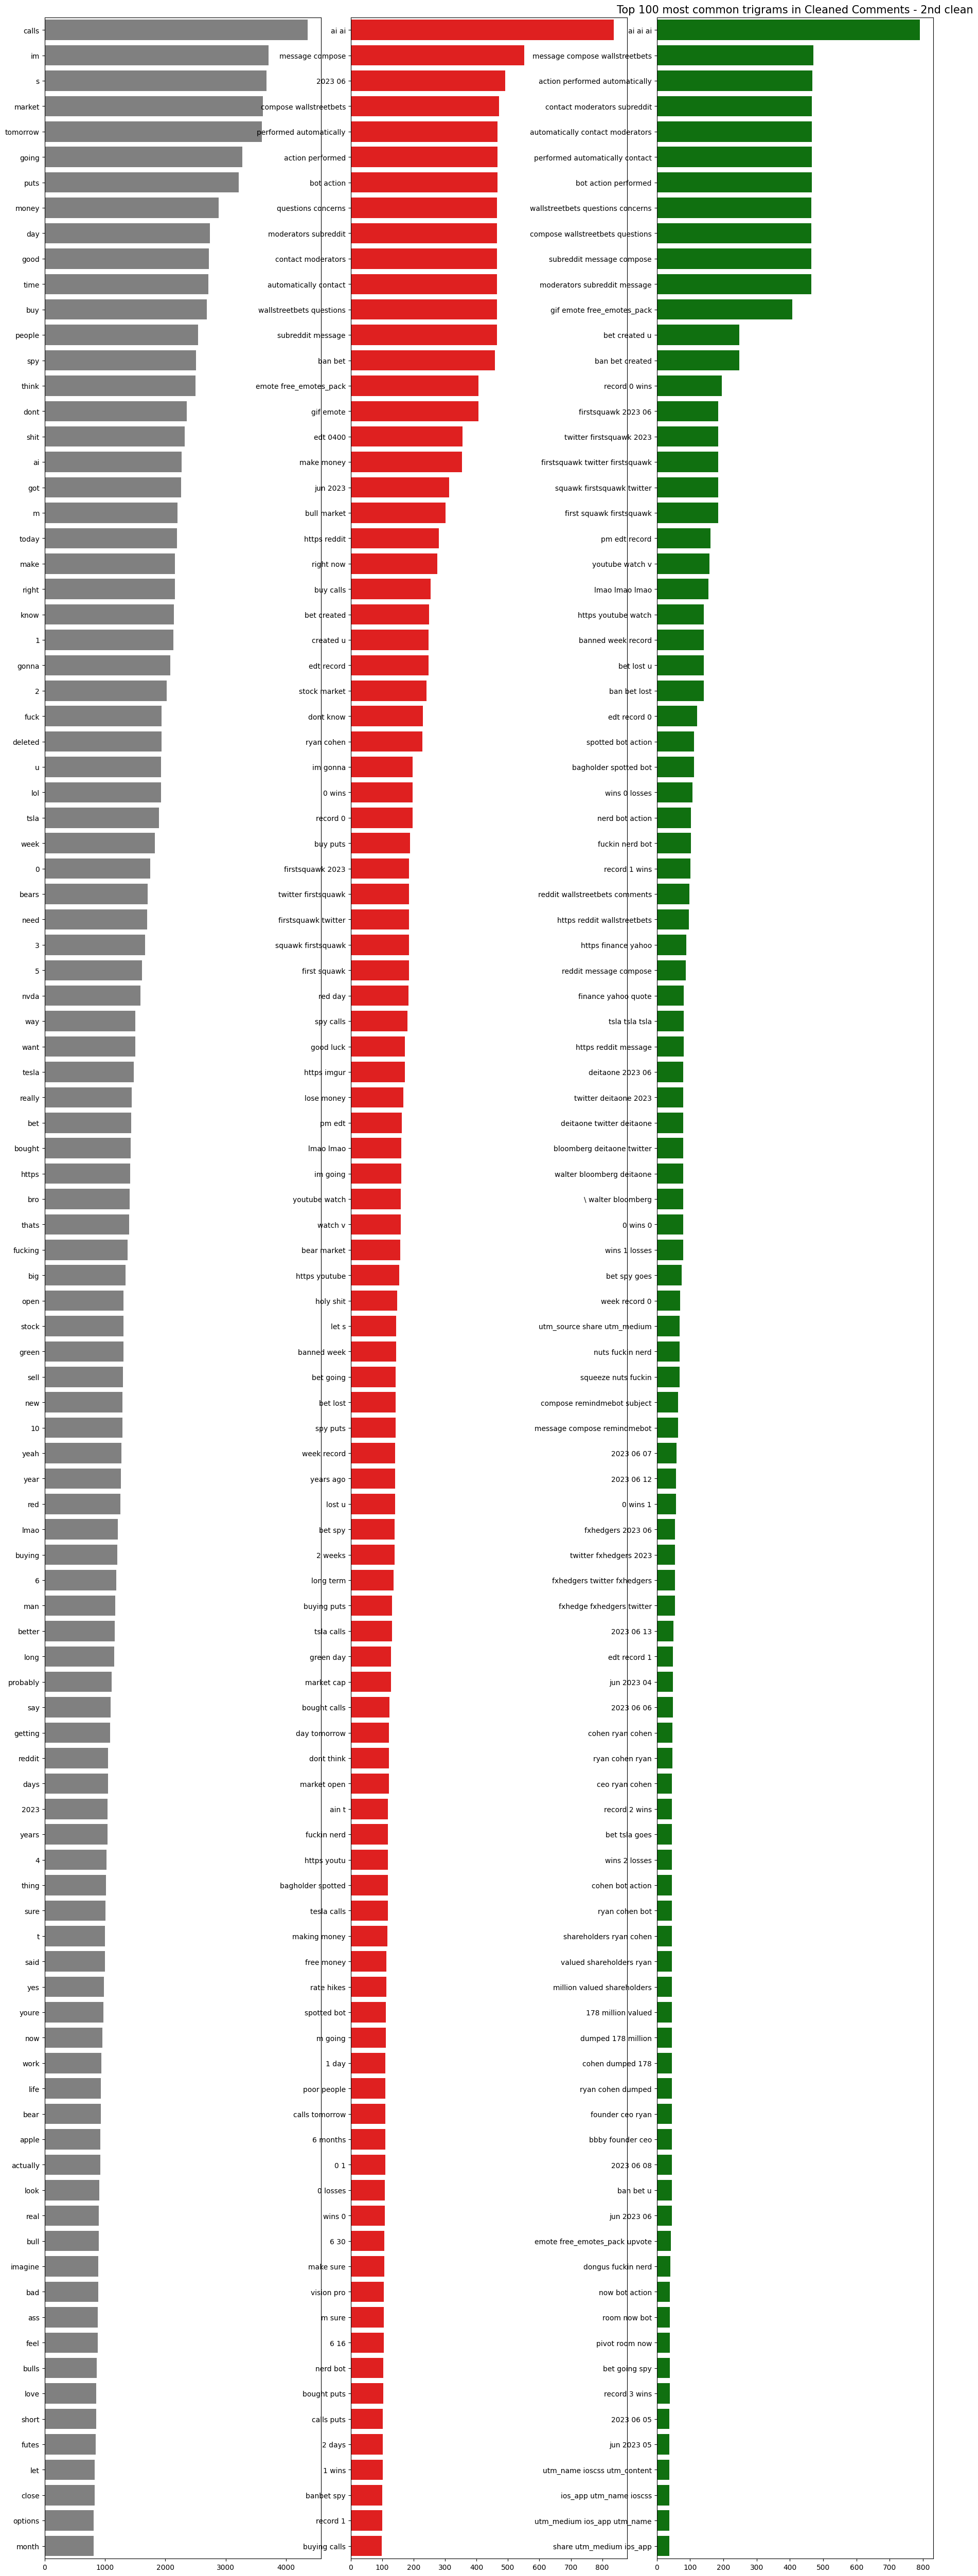

In [27]:
# 2nd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_second['grams'].values[:N], x=df_unigrams_cleaned_second['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_second['grams'].values[:N], x=df_bigrams_cleaned_second['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_second['grams'].values[:N], x=df_trigrams_cleaned_second['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 2nd clean', fontsize=15)

plt.show()

## 2.3. Clean per N-gram

In [28]:
# 3rd round cleaned
# criteria: by reading the N-gram ranking


%%time

def clean_second(comment):

    comment = re.sub(r"\bai ai ai\b", "ai", comment)
    comment = re.sub(r"\bai ai\b", "ai", comment)
    comment = re.sub(r'compose', '', comment)
    comment = re.sub(r'moderators', '', comment)
    comment = re.sub(r'\bm\b', '', comment)
    comment = re.sub(r'\bs\b', '', comment)
    comment = re.sub(r'\bu\b', '', comment)
    comment = re.sub(r'\b1\b', '', comment)
    comment = re.sub(r'\b2\b', '', comment)
    comment = re.sub(r'\bim\b', '', comment)
    comment = re.sub(r"   ", " ", comment)
    comment = re.sub(r"  ", " ", comment)


    return comment

consol_df['ngrams_embeddings_tokens'] = consol_df['embeddings_tokens'].apply(lambda s : clean_second(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(consol_df['ngrams_embeddings_tokens'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 3rd clean'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(consol_df['ngrams_embeddings_tokens'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 3rd clean'.format(fasttext_vocab_coverage, fasttext_text_coverage))

GloVe Embeddings cover 78.43% of vocabulary and 96.51% of text in Training Set - 3rd clean
FastText Embeddings cover 77.99% of vocabulary and 96.73% of text in Training Set - 3rd clean
CPU times: user 2.9 s, sys: 0 ns, total: 2.9 s
Wall time: 3.03 s


In [29]:
# 3rd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_third = defaultdict(int)

for cmt in consol_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_third[word] += 1

df_unigrams_cleaned_third = pd.DataFrame(sorted(consol_unigrams_cleaned_third.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_third = defaultdict(int)

for cmt in consol_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_third[word] += 1

df_bigrams_cleaned_third = pd.DataFrame(sorted(consol_bigrams_cleaned_third.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_third = defaultdict(int)

for cmt in consol_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_third[word] += 1

df_trigrams_cleaned_third = pd.DataFrame(sorted(consol_trigrams_cleaned_third.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_third

grams  count
0                       2023 06    491
1        message wallstreetbets    471
2       performed automatically    467
3              action performed    467
4                    bot action    467
...                         ...    ...
463465            average daily      1
463466          nvda historical      1
463467                   9 nvda      1
463468                returns 9      1
463469           average annual      1

[463470 rows x 2 columns]

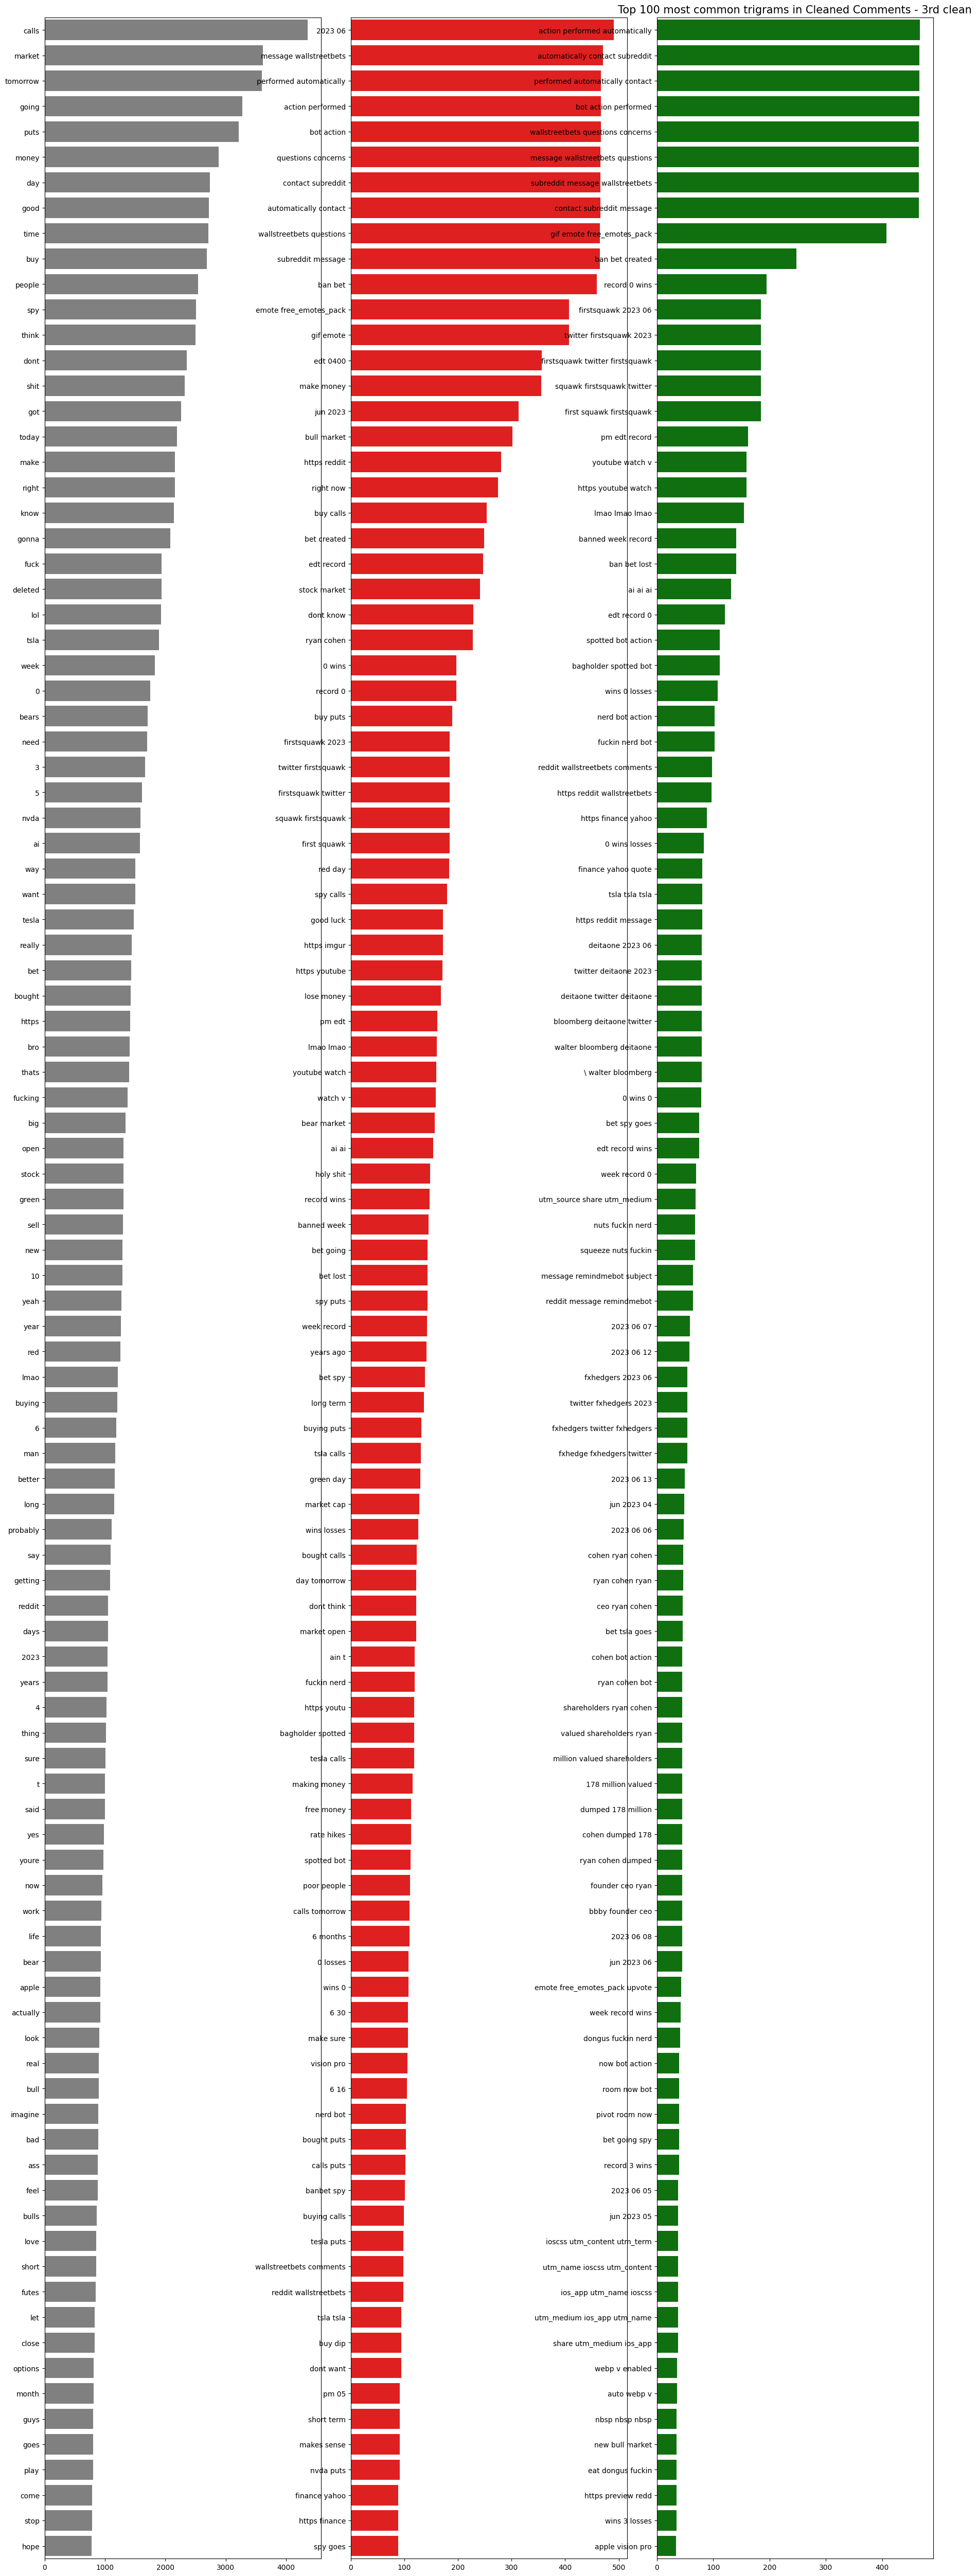

In [30]:
# 3rd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_third['grams'].values[:N], x=df_unigrams_cleaned_third['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_third['grams'].values[:N], x=df_bigrams_cleaned_third['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_third['grams'].values[:N], x=df_trigrams_cleaned_third['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 3rd clean', fontsize=15)

plt.show()

## 2.4. Stemming or lemmatization

In [31]:

# Stemming
consol_df['tokens'] = consol_df['ngrams_embeddings_tokens'].apply(word_tokenize)

# Step 2: Choose a Stemming or Lemmatization Algorithm
# Select a stemming or lemmatization algorithm
stemmer = PorterStemmer()

# Step 3: Apply Stemming or Lemmatization
# Apply the chosen algorithm to each token
consol_df['stemmed_tokens'] = consol_df['tokens'].apply(lambda x: [stemmer.stem(token) for token in x])
# Step 4: Reconstruct the Text
# Reconstruct the text by joining the stemmed or lemmatized tokens
consol_df['stemmed_text'] = consol_df['stemmed_tokens'].apply(lambda x: ' '.join(x))


In [32]:
# Lemmatization


# Select a stemming or lemmatization algorithm
lemmatizer = WordNetLemmatizer()
# Apply the chosen algorithm to each token
consol_df['lemmatized_tokens'] = consol_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
# Reconstruct the text by joining the stemmed or lemmatized tokens
consol_df['lemmatized_text'] = consol_df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

##2.5. Inspection after processing

In [33]:
#  Inspection after processing
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_final = defaultdict(int)

for cmt in consol_df['stemmed_text']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_final[word] += 1

df_unigrams_cleaned_final = pd.DataFrame(sorted(consol_unigrams_cleaned_final.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_final = defaultdict(int)

for cmt in consol_df['stemmed_text']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_final[word] += 1

df_bigrams_cleaned_final = pd.DataFrame(sorted(consol_bigrams_cleaned_final.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_final = defaultdict(int)

for cmt in consol_df['stemmed_text']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_final[word] += 1

df_trigrams_cleaned_final = pd.DataFrame(sorted(consol_trigrams_cleaned_final.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_final

grams  count
0                     gon na   2084
1                 make money    492
2                    2023 06    491
3                    ban bet    472
4       messag wallstreetbet    471
...                      ...    ...
423844          averag daili      1
423845           nvda histor      1
423846                9 nvda      1
423847              return 9      1
423848         averag annual      1

[423849 rows x 2 columns]

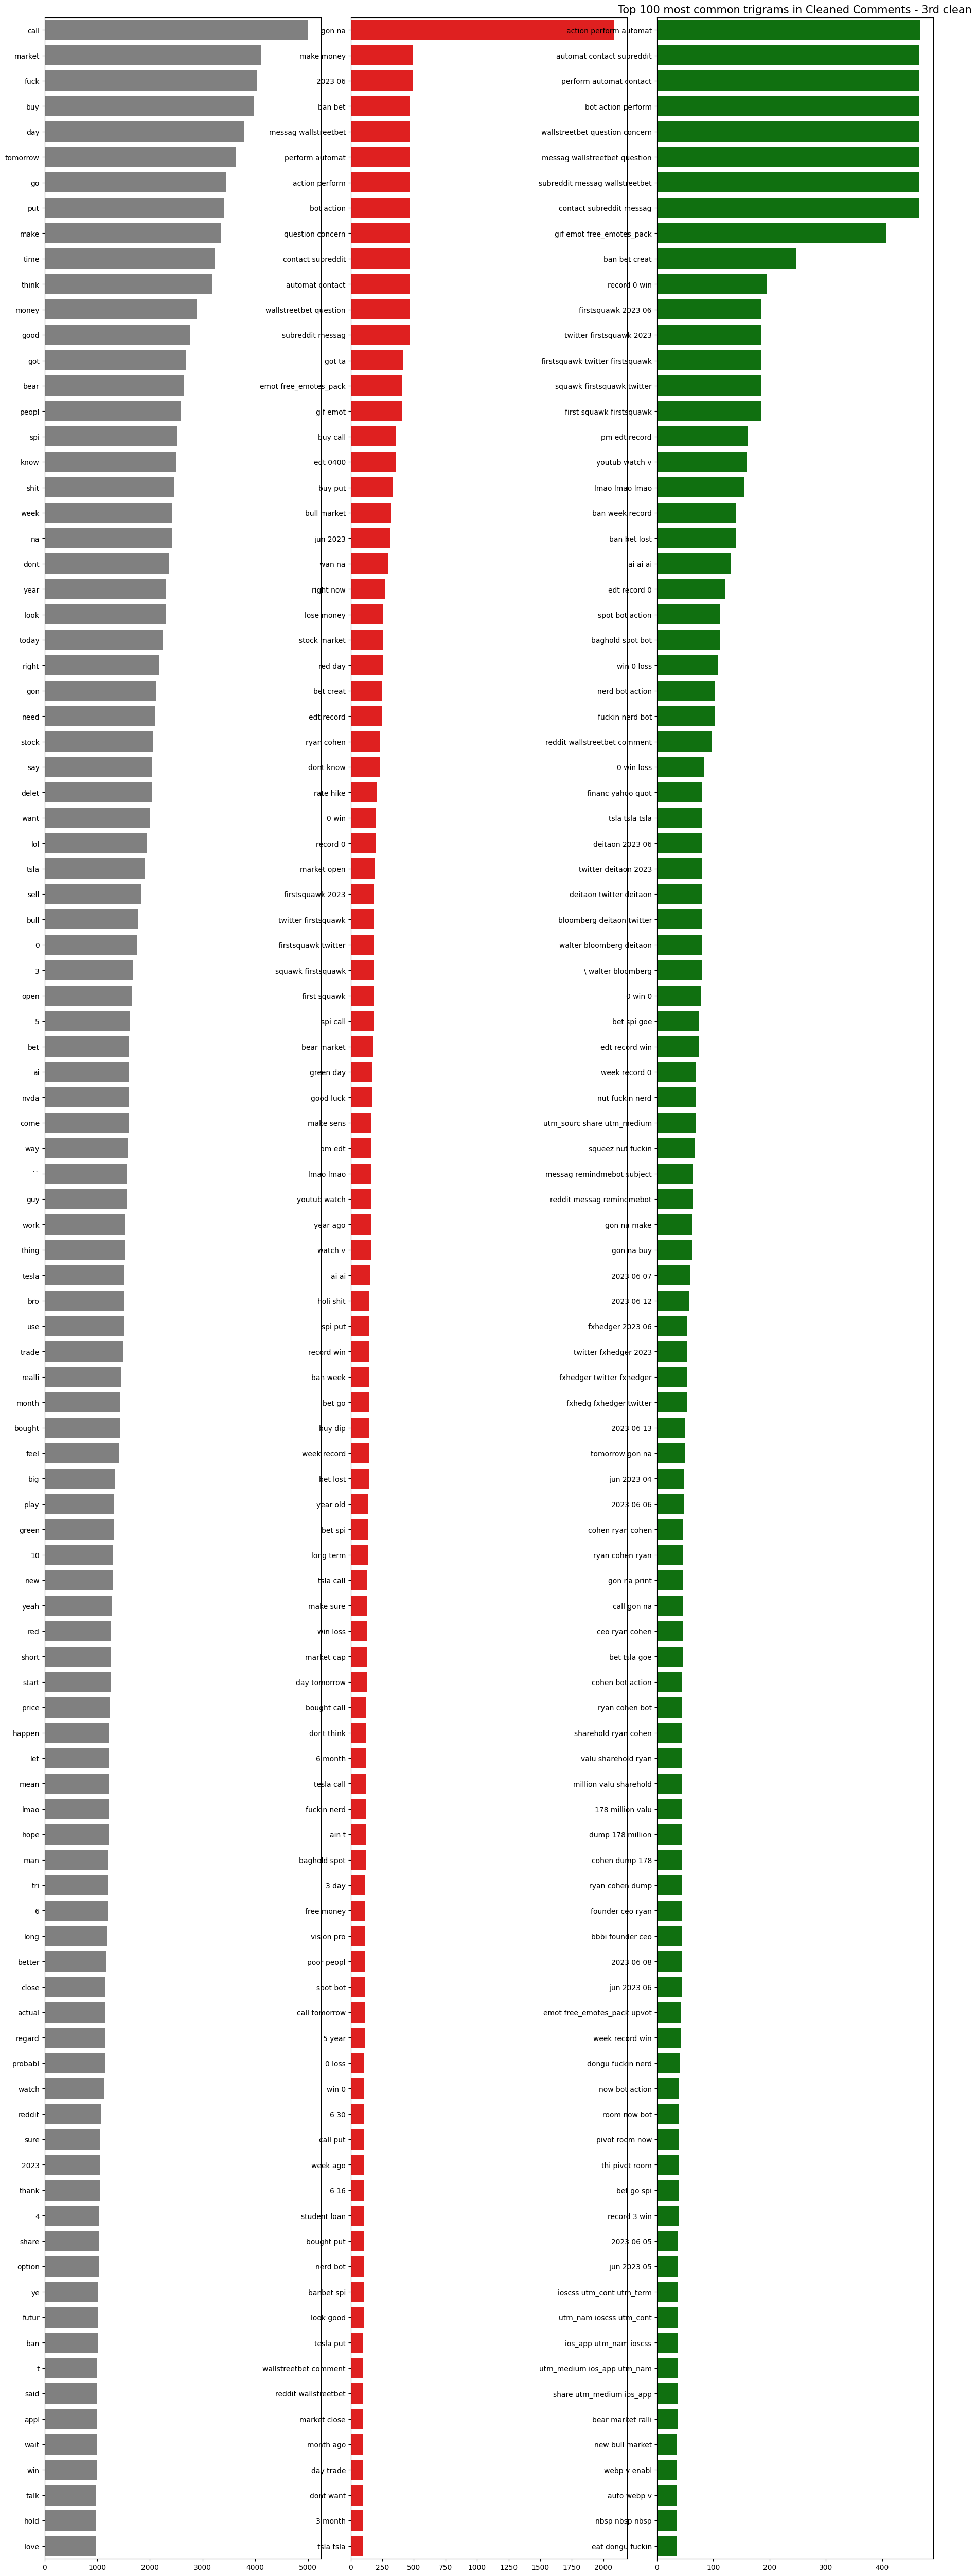

In [34]:
# Inspection after processing
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_final['grams'].values[:N], x=df_unigrams_cleaned_final['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_final['grams'].values[:N], x=df_bigrams_cleaned_final['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_final['grams'].values[:N], x=df_trigrams_cleaned_final['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 3rd clean', fontsize=15)

plt.show()

# 3. Features engineering

  1. Sentiment analysis on top n-grams
      - option 1 - NLTK
      - option 2 - Textblob
      - option 3 - specific for financial terms
  2. Topic classifification
  3. Frequency of Emoji
  4. Time-series



In [35]:
# Generate the list of N-grams
df_unigrams_cleaned_third_tomerge = df_unigrams_cleaned_third[:20]

'''
df_bigrams_cleaned_third_tomerge = df_bigrams_cleaned_third[:20]

df_trigrams_cleaned_third_tomerge = df_trigrams_cleaned_third[:20]
'''

df_unigrams_cleaned_third_tomerge


grams  count
0      calls   4360
1     market   3617
2   tomorrow   3598
3      going   3275
4       puts   3217
5      money   2887
6        day   2742
7       good   2718
8       time   2709
9        buy   2686
10    people   2539
11       spy   2508
12     think   2497
13      dont   2351
14      shit   2324
15       got   2263
16     today   2193
17      make   2161
18     right   2159
19      know   2143

In [36]:
# Generate the list of N-grams
# create a series contiaing first 100 unigram, bigram , trigram

list_top100gram = df_unigrams_cleaned_third_tomerge['grams']
          # pd.concat([df_unigrams_cleaned_third_tomerge['grams'] , df_bigrams_cleaned_third_tomerge['grams'] , df_trigrams_cleaned_third_tomerge['grams']], axis=0)
list_top100gram

0        calls
1       market
2     tomorrow
3        going
4         puts
5        money
6          day
7         good
8         time
9          buy
10      people
11         spy
12       think
13        dont
14        shit
15         got
16       today
17        make
18       right
19        know
Name: grams, dtype: object

In [69]:
# Generate the list of N-grams
# create a df containings n columns each with 1 key word, each row of record shows the count of frequency of each keyword in the raw text

df_top100gram = pd.DataFrame(columns=list_top100gram, index=consol_df.index)
for i, row in consol_df.iterrows():
    for gram in list_top100gram:
        count = row['ngrams_embeddings_tokens'].count(gram)
        df_top100gram.at[i, gram] = count

df_top100gram['title'] = consol_df['title']
df_top100gram

grams calls market tomorrow going puts money  day good time  buy  ...  spy  \
0       311    387      218   225  211   223  679  179  235  306  ...  169   
1       305    295      279   239  243   179  538  203  260  285  ...  145   
2       292    416      316   219  269   239  612  200  254  350  ...  207   
3       212    166      108   170  102   134  281  135  149  181  ...   84   
4       308    299      312   224  218   182  459  141  186  272  ...  177   
5       218    177      200   171  194   155  483  182  196  201  ...  160   
6       240    238      169   179  188   170  447  171  224  252  ...  145   
7       209    181      124   161  191   133  403  173  214  239  ...  156   
8        41     32       11    17   33    29  101   31   38   39  ...   33   
9        84     67       51    44   52    45  121   49   59   58  ...   37   
10      287    231      268   202  204   190  454  186  192  258  ...  144   
11      215    187      230   178  193   149  460  158  221  213  ...   94   
12      172    168      117   151  146   134  353  133  145  186  ...  100   
13      133    146       91   142  106    88  246   93  157  118  ...   73   
14      224    270      245   208  146   176  455  160  192  195  ...  142   
15      242    234      183   178  171   156  601  173  251  205  ...  155   
16      276    212      198   177  147   168  431  173  212  212  ...  148   
17      215    188      171   153  141   133  337  138  158  160  ...  120   
18      390    363      397   249  279   258  710  174  279  375  ...  262   

grams think dont shit  got today make right know  \
0       250  150  217  233   211  194   161  176   
1       215  169  201  231   155  209   161  216   
2       255  167  210  190   170  238   166  186   
3       165  108  149  130    31  135    97  123   
4       179  108  174  145   112  153   122  144   
5       179  121  202  194   157  132   147  149   
6       201  157  155  173    92  189   145  188   
7       180  156  187  158   138  177   149  160   
8        24   20   14   21    45   29    16   17   
9        55   31   37   54    10   38    41   40   
10      189  135  167  167   147  138   147  169   
11      180  147  167  179   166  144   162  164   
12      142   92  147  149   102  143   100  114   
13      105   91  117  126    28   99    90   94   
14      176  123  192  184   118  170   124  115   
15      219  138  203  198   167  135   159  142   
16      198  159  187  177   144  173   119  159   
17      135  110  131  156    57  113    84  114   
18      218  183  185  186   203  210   179  194   

grams                                        title  
0      What Are Your Moves Tomorrow, June 15, 2023  
1      What Are Your Moves Tomorrow, June 14, 2023  
2      What Are Your Moves Tomorrow, June 13, 2023  
3      What Are Your Moves Tomorrow, June 12, 2023  
4      What Are Your Moves Tomorrow, June 09, 2023  
5      What Are Your Moves Tomorrow, June 08, 2023  
6      What Are Your Moves Tomorrow, June 07, 2023  
7      What Are Your Moves Tomorrow, June 06, 2023  
8      What Are Your Moves Tomorrow, June 06, 2023  
9      What Are Your Moves Tomorrow, June 06, 2023  
10     What Are Your Moves Tomorrow, June 02, 2023  
11     What Are Your Moves Tomorrow, June 28, 2023  
12     What Are Your Moves Tomorrow, June 27, 2023  
13     What Are Your Moves Tomorrow, June 26, 2023  
14     What Are Your Moves Tomorrow, June 23, 2023  
15     What Are Your Moves Tomorrow, June 22, 2023  
16     What Are Your Moves Tomorrow, June 21, 2023  
17     What Are Your Moves Tomorrow, June 20, 2023  
18     What Are Your Moves Tomorrow, June 16, 2023  

[19 rows x 21 columns]

In [38]:
# Generate the list of N-grams
#back up the training data set

df_top100gram.to_csv('df_top20gram_Jun_testing.csv')

In [39]:
# adoption of sentiment analysis models
# option 1 - NLTK

sia = SentimentIntensityAnalyzer()

#apply sentiment analysis
df_top100gram_nltk = pd.DataFrame()
df_top100gram_nltk['grams'] = list_top100gram
df_top100gram_nltk['sentiment_score'] = list_top100gram.apply(lambda x: sia.polarity_scores(x))

df_top100gram_nltk

grams                                    sentiment_score
0      calls  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1     market  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2   tomorrow  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3      going  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4       puts  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
5      money  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6        day  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
7       good  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
8       time  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9        buy  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
10    people  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
11       spy  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
12     think  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
13      dont  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
14      shit  {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
15       got  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
16     today  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
17      make  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
18     right  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
19      know  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...

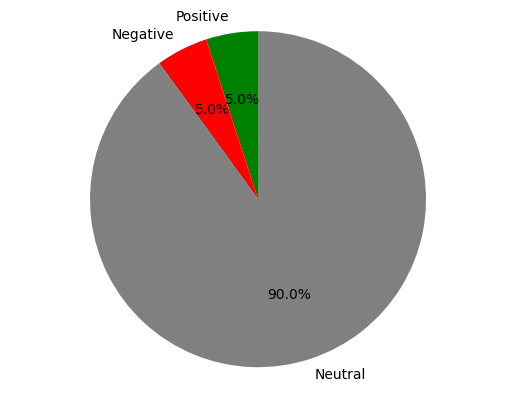

In [40]:
# option 1 - NLTK
#Statistics

# Initialize counters for different sentiment labels
positive_count = 0
negative_count = 0
neutral_count = 0

# Count the occurrences of each sentiment label
for scores in df_top100gram_nltk['sentiment_score']:
    compound_score = scores['compound']
    if compound_score > 0.05:
        positive_count += 1
    elif compound_score < -0.05:
        negative_count += 1
    else:
        neutral_count += 1

# Calculate the relative frequencies of each sentiment label
total_count = len(df_top100gram_nltk)
positive_percent = positive_count / total_count
negative_percent = negative_count / total_count
neutral_percent = neutral_count / total_count

# Visualize the sentiment distribution using a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percent, negative_percent, neutral_percent]
colors = ['green', 'red', 'gray']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

In [41]:
# option 2 - TextBlob

from textblob import TextBlob

In [42]:
# option 2 - TextBlob

# Perform sentiment analysis on each financial data point
sentiments_textblob = []

for word in list_top100gram:
    blob = TextBlob(word)
    polarity = blob.sentiment.polarity

    if polarity > 0:
        sentiment = "positive"
    elif polarity < 0:
        sentiment = "negative"
    else:
        sentiment = "neutral"

    sentiments_textblob.append({
        "Word": word,
        "Sentiment": sentiment
    })

sentiments_textblob_df = pd.DataFrame(sentiments_textblob)
print(sentiments_textblob_df)

# Convert sentiments list to a pandas DataFrame
df_top100gram_textblob = pd.DataFrame(sentiments_textblob)

df_top100gram_textblob

        Word Sentiment
0      calls   neutral
1     market   neutral
2   tomorrow   neutral
3      going   neutral
4       puts   neutral
5      money   neutral
6        day   neutral
7       good  positive
8       time   neutral
9        buy   neutral
10    people   neutral
11       spy   neutral
12     think   neutral
13      dont   neutral
14      shit  negative
15       got   neutral
16     today   neutral
17      make   neutral
18     right  positive
19      know   neutral


Word Sentiment
0      calls   neutral
1     market   neutral
2   tomorrow   neutral
3      going   neutral
4       puts   neutral
5      money   neutral
6        day   neutral
7       good  positive
8       time   neutral
9        buy   neutral
10    people   neutral
11       spy   neutral
12     think   neutral
13      dont   neutral
14      shit  negative
15       got   neutral
16     today   neutral
17      make   neutral
18     right  positive
19      know   neutral

In [43]:
df_top100gram_textblob.to_csv('gram_bert.csv')

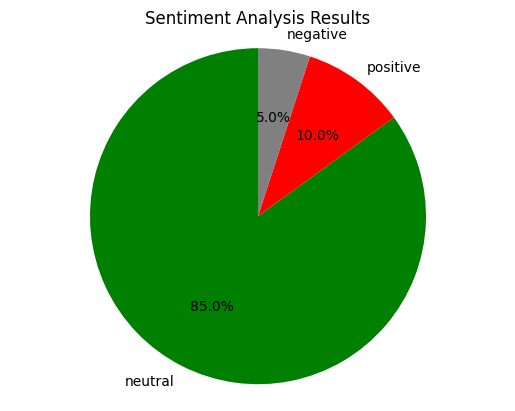

In [44]:
# option 2 - TextBlob
#Statistics

# Initialize counters for different sentiment labels
sentiment_counts = df_top100gram_textblob['Sentiment'].value_counts()
labels = sentiment_counts.index.tolist()
sizes = sentiment_counts.values.tolist()

colors = ['green', 'red', 'gray']  # Customize colors for positive, negative, and neutral sentiments

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart

plt.title('Sentiment Analysis Results')
plt.show()

In [45]:
#option 3 - specific for financial terms
# Embeddings

# Initialize an empty list to store word vectors
word_vectors = []

# Iterate over each word
for word in list_top100gram:
    try:
        # Get the word vector from the GloVe embeddings dictionary
        vector = glove_embeddings[word]
        word_vectors.append(vector)
    except KeyError:
        print(f"Word '{word}' not found in the glove_embeddings dictionary.")
        word_vectors.append(np.zeros(len(glove_embeddings[next(iter(glove_embeddings))])))

# Create a DataFrame with the word vectors
columns = [f"dim_{i}" for i in range(len(word_vectors[0]))]
glove_embeddings_df = pd.DataFrame(word_vectors, index=list_top100gram, columns=columns)
glove_embeddings_df.index.name = "Word"


glove_embeddings_df


dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
Word                                                                   
calls    -0.450250  0.516960 -0.333750  0.060965  0.474770  0.229420   
market   -0.196040  0.536560  0.096780  0.091406  0.552390 -0.356280   
tomorrow  0.229250  0.398980 -0.148250  0.199730  0.000208 -0.568790   
going    -0.058157  0.315030 -0.398830  0.079551  0.217990 -0.129720   
puts     -0.201530  0.091056  0.003293  0.136360  0.097221 -0.171100   
money    -0.750730  0.081650  0.090288 -0.347190 -0.605980 -0.026782   
day      -0.037723  0.278650  0.113530 -0.145210 -0.093572 -0.322320   
good     -0.426250  0.443100 -0.345170 -0.132600 -0.058160  0.052598   
time      0.172430  0.275020  0.050863 -0.196050 -0.238520  0.040335   
buy      -0.386460 -0.009301 -0.186450 -0.402890  0.018726  0.011056   
people   -0.196860  0.115790 -0.410910 -0.469980 -0.299720  0.067654   
spy      -0.117000 -0.589220  0.331510  0.244570 -0.208890  0.135550   
think    -0.217880  0.441280 -0.432040 -0.198030 -0.002797  0.288030   
dont     -0.353950  0.230510 -0.626890 -0.422340 -0.069675 -0.184420   
shit     -0.837120 -0.406320 -0.242020 -0.377190  0.005561  0.294150   
got      -0.149640  0.343360 -0.192040 -0.138900  0.099295  0.172660   
today    -0.156570  0.594890 -0.031445 -0.077586  0.278630 -0.509210   
make     -0.236610  0.152170 -0.455170  0.045883  0.090696 -0.099760   
right     0.244980  0.179730 -0.491910  0.124290  0.544700 -0.112580   
know     -0.026253  0.411140 -0.468080 -0.116070  0.220800  0.200590   

             dim_6     dim_7     dim_8   dim_9  ...   dim_290   dim_291  \
Word                                            ...                       
calls     0.196290 -0.323820 -0.181830  2.5717  ...  0.008461  0.279840   
market    0.044962  0.087634  0.160630  2.3887  ... -1.087800  0.476250   
tomorrow -0.086482  0.013450  0.012293  2.5562  ...  0.037572 -0.168290   
going    -0.009927  0.026302  0.201780  2.8812  ... -0.224540  0.110370   
puts     -0.315490 -0.329650  0.327910  2.1902  ... -0.112090 -0.111620   
money    -0.176440 -0.459730  0.485860  2.9120  ... -0.629920 -0.034711   
day      -0.164990  0.084118  0.187850  2.7747  ...  0.194380  0.032061   
good      0.215750 -0.367210 -0.045190  2.2444  ... -0.459070 -0.052783   
time     -0.126400 -0.207010  0.087383  2.7350  ... -0.103290  0.024095   
buy      -0.539730 -0.334090  0.088768  1.5371  ... -0.370450 -0.026144   
people   -0.088857  0.032210  0.256160  3.2108  ... -0.753030 -0.139340   
spy      -0.279110 -0.366130  0.399590  1.3202  ... -0.680210  0.155540   
think     0.080648 -0.146430  0.022300  2.5941  ... -0.150840  0.027544   
dont      0.390690 -0.629170  0.167040  1.4210  ... -0.098583 -0.264580   
shit     -0.216470 -0.550520 -0.081881  1.5943  ... -0.064707 -0.491280   
got       0.141720 -0.283900 -0.021703  2.4470  ... -0.152760  0.025371   
today    -0.066350 -0.081890 -0.047986  2.8036  ... -0.326580 -0.413380   
make      0.085486  0.082563  0.052556  2.3998  ... -0.371270  0.453290   
right    -0.228370 -0.042478  0.131430  2.6448  ...  0.004960  0.048956   
know      0.177820 -0.157600 -0.047263  2.6491  ... -0.257890 -0.110150   

           dim_292   dim_293   dim_294   dim_295   dim_296   dim_297  \
Word                                                                   
calls     0.003885  0.139370 -0.200980  0.168710 -0.078966  0.053021   
market    0.075284 -0.229940 -0.322600 -0.635040 -0.298900 -0.495300   
tomorrow  0.324900 -0.458550  0.035989 -0.395230  0.106990 -0.075183   
going    -0.070131 -0.055505  0.074806  0.204970 -0.105670  0.060989   
puts     -0.006606 -0.248460 -0.382450 -0.066595  0.040708 -0.031461   
money     0.096065 -0.162320  0.278560  0.049664  0.093182 -0.250060   
day       0.252870 -0.258230 -0.007297 -0.150810  0.003343  0.151850   
good     -0.320510 -0.121720  0.315450  0.045489  0.226440 -0.430300   
time     -0.217210 -0.082729  0.217850 -0.067727 -0.31506

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

# Input dataset (list of words and labels)
dataset = [
    ("calls", "positive"),
    ("market", "neutral"),
    ("tomorrow", "neutral"),
    ("going", "neutral"),
    ("puts", "negative"),
    ("money", "neutral"),
    ("day", "neutral"),
    ("good", "positive"),
    ("time", "neutral"),
    ("buy", "positive"),
    ("people", "neutral"),
    ("spy", "positive"),
    ("think", "neutral"),
    ("dont", "neutral"),
    ("shit", "negative"),
    ("got", "neutral"),
    ("today", "neutral"),
    ("make", "neutral"),
    ("right", "positive"),
    ("know", "neutral"),
]

# Separate words and labels
words, labels = zip(*dataset)

# Calculate sentiment scores
sentiment_scores = {}
sentiment_categories = set(labels)

for category in sentiment_categories:
    # Collect word embeddings for the given sentiment category
    category_embeddings = [glove_embeddings[word] for word, label in dataset if label == category]

    # Calculate the average vector
    average_vector = np.mean(category_embeddings, axis=0)

    sentiment_scores[category] = average_vector

# Calculate sentiment scores for each word
word_sentiment_scores = {}

for word in words:
    word_vector = glove_embeddings[word]
    cosine_similarities = cosine_similarity([word_vector], list(sentiment_scores.values()))[0]
    word_sentiment_scores[word] = dict(zip(sentiment_scores.keys(), cosine_similarities))

# Create a DataFrame with the sentiment scores
df_cos_sim = pd.DataFrame.from_dict(word_sentiment_scores, orient='index')
df_cos_sim.columns = [f"{category.capitalize()} Sentiment Score" for category in sentiment_categories]
df_cos_sim.index.name = "Word"

df_cos_sim

Negative Sentiment Score  Positive Sentiment Score  \
Word                                                           
calls                     0.426462                  0.584945   
market                    0.279249                  0.498796   
tomorrow                  0.396394                  0.462622   
going                     0.590834                  0.699867   
puts                      0.764930                  0.561953   
money                     0.476800                  0.620815   
day                       0.383891                  0.533617   
good                      0.546050                  0.733853   
time                      0.425128                  0.621216   
buy                       0.320690                  0.653323   
people                    0.503115                  0.596604   
spy                       0.276726                  0.578742   
think                     0.603052                  0.657849   
dont                      0.626229                  0.557243   
shit                      0.893507                  0.527253   
got                       0.566882                  0.611957   
today                     0.374923                  0.539786   
make                      0.516918                  0.707644   
right                     0.577006                  0.711751   
know                      0.579496                  0.684341   

          Neutral Sentiment Score  
Word                               
calls                    0.450458  
market                   0.549459  
tomorrow                 0.682611  
going                    0.880800  
puts                     0.493274  
money                    0.679805  
day                      0.723153  
good                     0.740866  
time                     0.761664  
buy                      0.544337  
people                   0.751063  
spy                      0.250532  
think                    0.830043  
dont                     0.696171  
shit                     0.594440  
got                      0.748683  
today                    0.711324  
make                     0.776041  
right                    0.715192  
know                     0.860983

In [74]:

# Iterate over each row in df_top100gram
for index, row in df_top100gram.iterrows():
    # Calculate the sum of all words frequency * positive sentiment score
    positive_sum = (row.iloc[:-1] * df_cos_sim['Positive Sentiment Score']).sum()

    # Calculate the sum of all words frequency * negative sentiment score
    negative_sum = (row.iloc[:-1] * df_cos_sim['Negative Sentiment Score']).sum()

    # Calculate the sum of all words frequency * neutral sentiment score
    neutral_sum = (row.iloc[:-1] * df_cos_sim['Neutral Sentiment Score']).sum()

    # Append the scores as new columns to df_top100gram
    df_top100gram.at[index, 'Positive Score'] = positive_sum
    df_top100gram.at[index, 'Negative Score'] = negative_sum
    df_top100gram.at[index, 'Neutral Score'] = neutral_sum

# Print the updated df_top100gram
print(df_top100gram)

grams  calls  market  tomorrow  going  puts  money  day  good  time  buy  ...  \
0        311     387       218    225   211    223  679   179   235  306  ...   
1        305     295       279    239   243    179  538   203   260  285  ...   
2        292     416       316    219   269    239  612   200   254  350  ...   
3        212     166       108    170   102    134  281   135   149  181  ...   
4        308     299       312    224   218    182  459   141   186  272  ...   
5        218     177       200    171   194    155  483   182   196  201  ...   
6        240     238       169    179   188    170  447   171   224  252  ...   
7        209     181       124    161   191    133  403   173   214  239  ...   
8         41      32        11     17    33     29  101    31    38   39  ...   
9         84      67        51     44    52     45  121    49    59   58  ...   
10       287     231       268    202   204    190  454   186   192  258  ...   
11       215     187       2

# 4. Prepare the Training dataset
  - check for Duplicated labeled records

In [ ]:
# 2. Prepare the Training dataset
# Check for Duplicated labeled records
'''
# extract the list of "text"
df_mislabeled = consol_df.groupby(['comments']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

'''

'\n# extract the list of "text"\ndf_mislabeled = consol_df.groupby([\'comments\']).nunique().sort_values(by=\'target\', ascending=False)\ndf_mislabeled = df_mislabeled[df_mislabeled[\'target\'] > 1][\'target\']\ndf_mislabeled.index.tolist()\n\n'

In [ ]:
# Check for Duplicated labeled records
# review and relabel the text one by one

what if the keyword is new and never trained before in model?
- Ngrams & embeddings


In [ ]:
'''
# Scikit-learn庫中的StratifiedKFold類別，它可以將資料集分為K個互斥的子集，以便進行交叉驗證
# 為了確保每個子集都能夠代表整個資料集的類別分佈
K = 3
skf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)

DISASTER = train_df['target'] == 1
print('Whole Training Set Shape = {}'.format(train_df.shape))
print('Whole Training Set Unique keyword Count = {}'.format(train_df['keyword'].nunique()))
print('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(train_df[DISASTER]['target_relabeled'].count(), train_df[~DISASTER]['target_relabeled'].count()))

#在每個子集的迭代中，程式碼選擇訓練集和驗證集中文本數據的子集，然後使用shape屬性顯示它們的形狀。這將顯示訓練集中有多少行和列，以及驗證集中有多少行和列
# 接下來，計算訓練集和驗證集中關鍵字的唯一數量, 了解訓練集和驗證集之間的關鍵字分佈是否相似，進而確定模型是否過度擬合
# 每次迭代都會得到一個訓練集和一個驗證集的索引，這些索引可以用來從原始數據集中選擇相應的樣本進行訓練和驗證
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df['text_cleaned'], train_df['target']), 1):
    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'text_cleaned'].shape, train_df.loc[val_idx, 'text_cleaned'].shape))
    print('Fold {} Training Set Unique keyword Count = {} - Validation Set Unique keyword Count = {}'.format(fold, train_df.loc[trn_idx, 'keyword'].nunique(), train_df.loc[val_idx, 'keyword'].nunique()))


'''

"\n# Scikit-learn庫中的StratifiedKFold類別，它可以將資料集分為K個互斥的子集，以便進行交叉驗證\n# 為了確保每個子集都能夠代表整個資料集的類別分佈\nK = 3\nskf = StratifiedKFold(n_splits=K, random_state=SEED, shuffle=True)\n\nDISASTER = train_df['target'] == 1\nprint('Whole Training Set Shape = {}'.format(train_df.shape))\nprint('Whole Training Set Unique keyword Count = {}'.format(train_df['keyword'].nunique()))\nprint('Whole Training Set Target Rate (Disaster) {}/{} (Not Disaster)'.format(train_df[DISASTER]['target_relabeled'].count(), train_df[~DISASTER]['target_relabeled'].count()))\n\n#在每個子集的迭代中，程式碼選擇訓練集和驗證集中文本數據的子集，然後使用shape屬性顯示它們的形狀。這將顯示訓練集中有多少行和列，以及驗證集中有多少行和列\n# 接下來，計算訓練集和驗證集中關鍵字的唯一數量, 了解訓練集和驗證集之間的關鍵字分佈是否相似，進而確定模型是否過度擬合\n# 每次迭代都會得到一個訓練集和一個驗證集的索引，這些索引可以用來從原始數據集中選擇相應的樣本進行訓練和驗證\nfor fold, (trn_idx, val_idx) in enumerate(skf.split(train_df['text_cleaned'], train_df['target']), 1):\n    print('\nFold {} Training Set Shape = {} - Validation Set Shape = {}'.format(fold, train_df.loc[trn_idx, 'text_cleaned'].shape, train_df.loc[val_idx, 'tex